# Property Sales

This data comes from the Annualized Rolling Sales dataset on NYC Open Data:

https://data.cityofnewyork.us/Housing-Development/Annualized-Rolling-Sales-Update/uzf5-f8n2

In [1]:
import urllib.request
import PyPDF2
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# Uncomment if you need to run these cells again
# url = 'https://data.cityofnewyork.us/api/views/uzf5-f8n2/files/8d9ba1d7-9b7a-43de-b741-bd9a35839e03?filename' + \
    # '=Annualized%20Rolling%20Sales%20Update.zip'
# urllib.request.urlretrieve(url, 'rolling_sales.zip')
# !mkdir data/rolling_sales
# !unzip rolling_sales.zip -d data/rolling_sales
# !rm -r rolling_sales.zip

In [3]:
# Get a list of all the downloaded files
!ls data/rolling_sales

2009_bronx.xls              2015_queens.xls
2009_brooklyn.xls           2015_statenisland.xls
2009_manhattan.xls          glossary_rsf071607.pdf
2009_queens.xls             sales_2007_bronx.xls
2009_statenisland.xls       sales_2007_brooklyn.xls
2010_bronx.xls              sales_2007_manhattan.xls
2010_brooklyn.xls           sales_2007_queens.xls
2010_manhattan.xls          sales_2007_statenisland.xls
2010_queens.xls             sales_2008_bronx.xls
2010_statenisland.xls       sales_2008_brooklyn.xls
2011_bronx.xls              sales_2008_manhattan.xls
2011_brooklyn.xls           sales_2008_queens.xls
2011_manhattan.xls          sales_2008_statenisland.xls
2011_queens.xls             sales_bronx_03.xls
2011_statenisland.xls       sales_bronx_04.xls
2012_bronx.xls              sales_bronx_05.xls
2012_brooklyn.xls           sales_bronx_06.xls
2012_manhattan.xls          sales_brooklyn_03.xls
2012_queens.xls             sales_brooklyn_04.xls
2012_statenisland.xls       sales_brooklyn_05.x

## Reading the glossary PDF
   
I used the PyPDF2 library to read this PDF.

In [4]:
gloss = PyPDF2.PdfFileReader('data/rolling_sales/glossary_rsf071607.pdf')

In [5]:
for i in range(gloss.getNumPages()):
    print("Page {}:".format(i))
    print("")
    print(gloss.getPage(i).extractText())
    print("")

Page 0:

        I. GLOSSARY OF TERMS 
 II.     HOW TO POWER SORT FROM EXCEL 
Glossary of Terms for Property Sales Files  I. GLOSSARY OF TERMS The following terms follow the column headings across the spreadsheet, from left to right.   Borough:  The name of the borough in which the property is located.  Neighborhood: Department of Finance assessors determine the neighborhood name in the course of valuing properties. The common name of the neighborhood is generally the same as the name Finance designates. However, there may be slight differences in neighborhood boundary lines and some sub-neighborhoods may not be included.  Building Class Category: 
This is a field that we are including so that users of the Rolling Sales Files can easily identify similar properties by broad usage (e.g. One Family Homes) without looking up individual Building Classes. Files are sorted by Borough, Neighborhood, Building Class Category, Block and Lot.  Tax Class at Present: Every property in the city is as

# Brooklyn data

I checked the columns for all the data between 2009 and 2015 and they all share the same column names (once you strip whitespace), allowing these dataframes to be merged without losing any data.

In [6]:
bk_dfs = []
# Used separate skiprows values since Excel files were formatted slightly differently
for i in range(3,7): # For the years 2003 to 2006
    temp_df = pd.read_excel('data/rolling_sales/sales_brooklyn_0{}.xls'.format(i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)
for i in range(2007,2009): # For 2007 and 2008
    temp_df = pd.read_excel('data/rolling_sales/sales_{}_brooklyn.xls'.format(i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)
for i in range(2009, 2011): # For 2009 and 2010
    temp_df = pd.read_excel('data/rolling_sales/{}_brooklyn.xls'.format(i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)
for i in range(2011, 2016): # For 2011 to 2015
    temp_df = pd.read_excel('data/rolling_sales/{}_brooklyn.xls'.format(i), skiprows=4)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)

In [7]:
bk_df = pd.concat(bk_dfs)

In [8]:
bk_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,BATH BEACH,01 ONE FAMILY HOMES,1,6363,38,,B3,1602 86 STREET,,...,2,0,2,1439,2090,1901,1,A5,0,2003-08-01
1,3,BATH BEACH,01 ONE FAMILY HOMES,1,6364,45,,S1,1652 86 STREET,,...,1,1,2,1200,1620,1926,1,S1,450000,2003-01-24
2,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,44,,S1,1690 86 STREET,,...,1,1,2,1473,1656,1931,1,S1,0,2003-10-08
3,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,44,,S1,1690 86 STREET,,...,1,1,2,1473,1656,1931,1,S1,0,2003-04-02
4,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,143,,S1,1686 86 STREET,,...,1,1,2,1473,1656,1929,1,S1,0,2003-04-02


In [27]:
sorted(bk_df.columns)

['ADDRESS',
 'APARTMENT NUMBER',
 'BLOCK',
 'BOROUGH',
 'BUILDING CLASS AT PRESENT',
 'BUILDING CLASS AT TIME OF SALE',
 'BUILDING CLASS CATEGORY',
 'COMMERCIAL UNITS',
 'EASE-MENT',
 'GROSS SQUARE FEET',
 'LAND SQUARE FEET',
 'LOT',
 'NEIGHBORHOOD',
 'RESIDENTIAL UNITS',
 'SALE DATE',
 'SALE PRICE',
 'TAX CLASS AT PRESENT',
 'TAX CLASS AT TIME OF SALE',
 'TOTAL UNITS',
 'YEAR BUILT',
 'ZIP CODE']

In [9]:
# We have data for 159,427 sales
print("Total number of Brooklyn sales: {}".format(bk_df.shape[0]))

Total number of Brooklyn sales: 347004


In [10]:
# Strip trailing white space from neighborhoods to make our lives easier
bk_df['NEIGHBORHOOD'] = bk_df['NEIGHBORHOOD'].str.strip()
# Number of sales from Red Hook
print("Total number of sales in Red Hook: {}".format(bk_df[bk_df['NEIGHBORHOOD'] == 'RED HOOK'].count()[0]))

Total number of sales in Red Hook: 1204


## Grouping data by time

To prepare the data for grouping by time, I created a new dataframe indexed by the sale date. Then I created a separate dataframe for Red Hook sales only.

In [11]:
# All Brooklyn sales indexed by the sale date
bk_groups = bk_df.set_index('SALE DATE')
bk_groups.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
SALE DATE,,,,,,,,,,,,,,,,,,,,
2003-08-01,3,BATH BEACH,01 ONE FAMILY HOMES,1,6363,38,,B3,1602 86 STREET,,11214,2,0,2,1439,2090,1901,1,A5,0
2003-01-24,3,BATH BEACH,01 ONE FAMILY HOMES,1,6364,45,,S1,1652 86 STREET,,11214,1,1,2,1200,1620,1926,1,S1,450000
2003-10-08,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,44,,S1,1690 86 STREET,,11214,1,1,2,1473,1656,1931,1,S1,0
2003-04-02,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,44,,S1,1690 86 STREET,,11214,1,1,2,1473,1656,1931,1,S1,0
2003-04-02,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,143,,S1,1686 86 STREET,,11214,1,1,2,1473,1656,1929,1,S1,0


In [12]:
"""
Grouping all Brooklyn sales by the month of the sale date and taking the mean of each column (including 
sale price)
"""
bk_monthly_means = bk_groups.resample('M').mean()
bk_monthly_means.head()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
SALE DATE,,,,,,,,,,,,
2003-01-31,3.0,5002.362958,248.595805,11210.258087,2.345183,0.202986,2.548169,2193.651973,2833.476004,1570.884109,1.643441,222102.817277
2003-02-28,3.0,4303.197807,143.452632,11185.343860,2.896930,0.108772,3.005702,2323.556140,3230.620614,1728.825439,1.471491,271968.140351
2003-03-31,3.0,4404.031976,122.757137,11198.421013,2.229159,0.152646,2.381804,2270.032737,2795.135516,1769.652075,1.486106,244579.618196
2003-04-30,3.0,4305.151515,149.426407,11219.826840,2.411977,0.121934,2.533911,2100.076840,2837.883478,1694.950577,1.487013,205382.258658
2003-05-31,3.0,4452.525163,140.875385,11204.519685,2.824375,0.158850,2.983225,2450.905169,3413.740500,1703.421431,1.542965,252179.353304


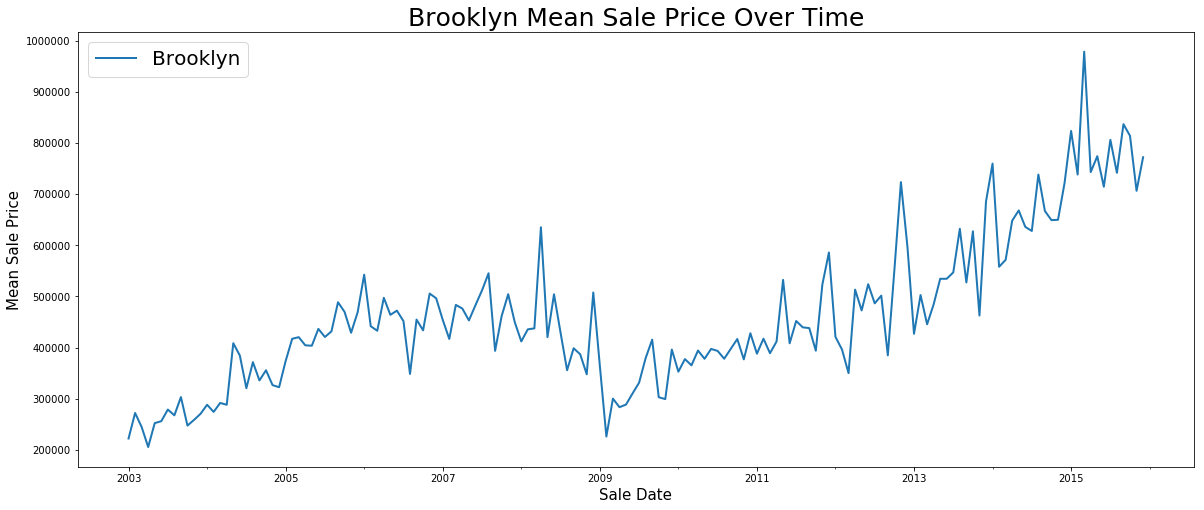

In [13]:
# Mean sale price of all buildings in Brooklyn
f, ax = plt.subplots(figsize=(20,8))
bk_monthly_means['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='Brooklyn')
plt.title("Brooklyn Mean Sale Price Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

In [14]:
bk_monthly_means.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
count,156.0,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,3.0,4242.797727,275.997423,11215.965801,2.530728,0.185801,2.725829,2536.554040,3092.897270,1689.666000,1.660856,463205.024723
std,0.0,221.978316,86.874790,6.618905,1.106474,0.053552,1.102138,1331.114228,748.188611,83.431332,0.101909,147121.960218
min,3.0,3683.353098,115.586853,11184.024838,1.691774,0.101876,1.904915,1474.387991,1924.045727,1300.736321,1.471491,205382.258658
25%,3.0,4090.803959,208.676355,11214.528079,2.123814,0.156605,2.316601,2034.883583,2687.895348,1652.242981,1.585766,377264.548547
50%,3.0,4254.269946,280.128788,11219.015037,2.344811,0.172725,2.530649,2265.553005,2952.772140,1708.683243,1.663586,433222.942047
75%,3.0,4398.674204,320.942407,11219.657717,2.577463,0.201522,2.821225,2520.222913,3307.009106,1746.342558,1.718068,524703.424003
max,3.0,5002.362958,561.677801,11232.175353,11.989418,0.570942,12.152958,15634.910325,8127.562429,1789.010087,2.274120,978678.485184


# Red Hook only

To dos:
* Figure out how they labeled sales as belonging to Red Hook or not
* Is there a better way to do this? Maybe get a list of all block and lot numbers that fall within Red Hook/our target study area? Then we could check the sales listed in this dataset against that list.

In [15]:
rh_df = bk_df[bk_df['NEIGHBORHOOD'] == 'RED HOOK']
rh_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
29763,3,RED HOOK,01 ONE FAMILY HOMES,1,520,23,,A9,694 HICKS STREET,,...,1,0,1,1901,2604,1899,1,A9,0,2003-07-25
29764,3,RED HOOK,01 ONE FAMILY HOMES,1,556,38,,A9,62A SULLIVAN STREET,,...,1,0,1,2000,360,1940,1,A9,0,2003-01-03
29765,3,RED HOOK,01 ONE FAMILY HOMES,1,586,36,,A9,140 COFFEY STREET,,...,1,0,1,2000,900,1899,1,A9,0,2003-02-10
29766,3,RED HOOK,01 ONE FAMILY HOMES,1,596,47,,A9,161 COFFEY STREET,,...,1,0,1,1667,1536,1899,1,A9,0,2003-04-14
29767,3,RED HOOK,01 ONE FAMILY HOMES,1,603,32,,A9,156 BEARD STREET,,...,1,0,1,2000,1400,1899,1,A9,0,2003-03-11


In [16]:
rh_groups = rh_df.set_index('SALE DATE')

In [17]:
"""
Grouping all Red Hook sales by the month of the sale date and taking the mean of each column (including 
sale price).
"""
rh_monthly_means = rh_groups.resample('M').mean()
rh_monthly_means.head()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
SALE DATE,,,,,,,,,,,,
2003-01-31,3.0,538.062500,14.75,11231.0,2.312500,0.562500,2.875000,7136.187500,4243.937500,1662.812500,2.1875,450625.0
2003-02-28,3.0,558.533333,90.60,11231.0,0.933333,0.333333,1.266667,2188.266667,2063.866667,1541.066667,2.0000,291417.0
2003-03-31,3.0,569.900000,30.90,11231.0,2.200000,0.100000,2.300000,19314.600000,2219.800000,1537.900000,1.9000,871859.0
2003-04-30,3.0,562.400000,22.60,11231.0,1.300000,0.300000,1.600000,2712.700000,1932.800000,1734.400000,1.6000,250206.2
2003-05-31,3.0,543.200000,22.40,11231.0,1.200000,0.000000,1.200000,2866.000000,915.200000,1145.000000,2.8000,251800.0


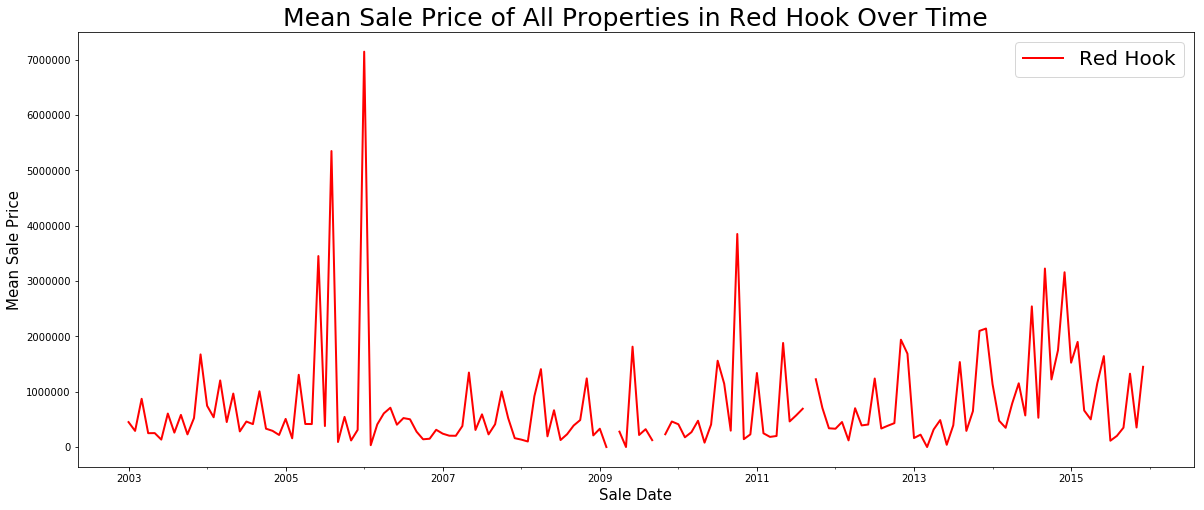

In [18]:
# Mean sale price of all buildings in Brooklyn
f, ax = plt.subplots(figsize=(20,8))
rh_monthly_means['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,c='r',label='Red Hook')
plt.title("Mean Sale Price of All Properties in Red Hook Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

## Note:

We can see from the above plot that the mean is less informative since there is such a large variation from month to month in the mean sales price (the mean for some months is 0 or less than 500,000 dollars but more than 3,000,000 dollars for other months). This is due to the relatively small total number of sales within Red Hook (only 533 for the entire dataset).

## Counts

Count of the number of sales per month.

In [19]:
bk_monthly_counts = bk_groups.resample('M').count()
rh_monthly_counts = rh_groups.resample('M').count()

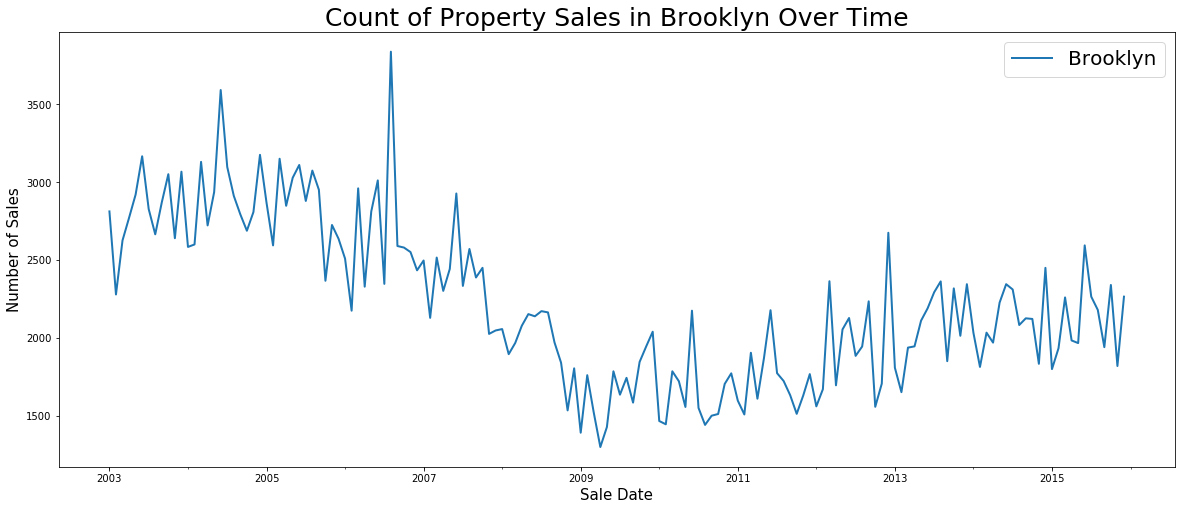

In [20]:
f, ax = plt.subplots(figsize=(20,8))
bk_monthly_counts['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='Brooklyn')
plt.title("Count of Property Sales in Brooklyn Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Number of Sales", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

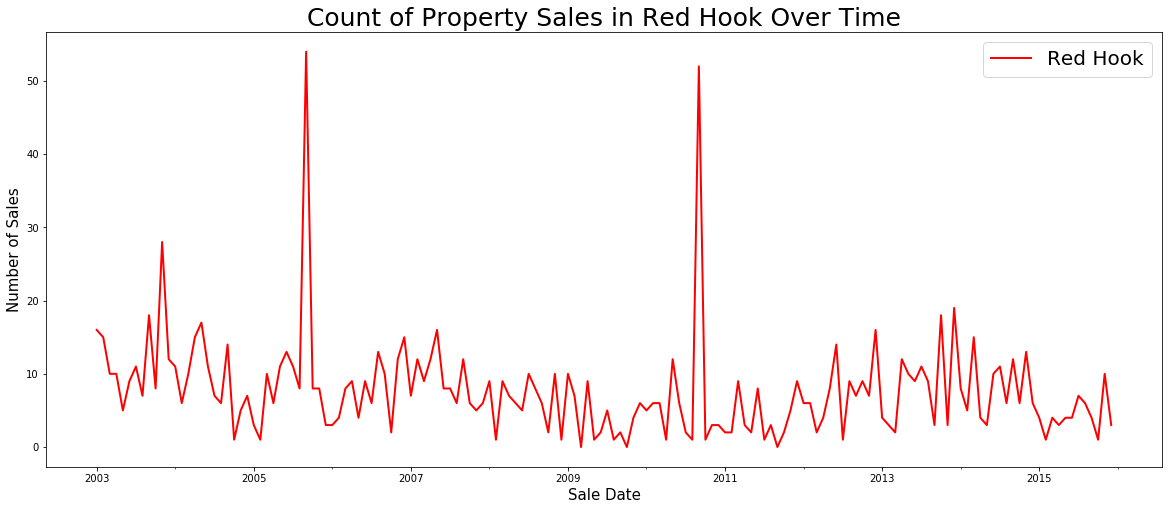

In [21]:
f, ax = plt.subplots(figsize=(20,8))
rh_monthly_counts['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='Red Hook',color='r')
plt.title("Count of Property Sales in Red Hook Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Number of Sales", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

## Note:

We see a gradual rise in the total number of properties sold per month in Brooklyn. In Red Hook, though, we see a spike in total sales late 2010 (around the same time that we saw a mean sale price of close to 4 million dollars) and then fairly consistent sales between 2011 and 2016.

# Residential sales only

In [22]:
# For Brooklyn
bk_res = bk_df[bk_df['RESIDENTIAL UNITS']>0]
bk_res_groups = bk_res.set_index('SALE DATE')
bk_res_counts = bk_res_groups.resample('M').count()
bk_res_mean = bk_res_groups.resample('M').mean()

In [23]:
# For Red Hook
rh_res = rh_df[rh_df['RESIDENTIAL UNITS']>0]
rh_res_groups = rh_res.set_index('SALE DATE')
rh_res_counts = rh_res_groups.resample('M').count()
rh_res_mean = rh_res_groups.resample('M').mean()

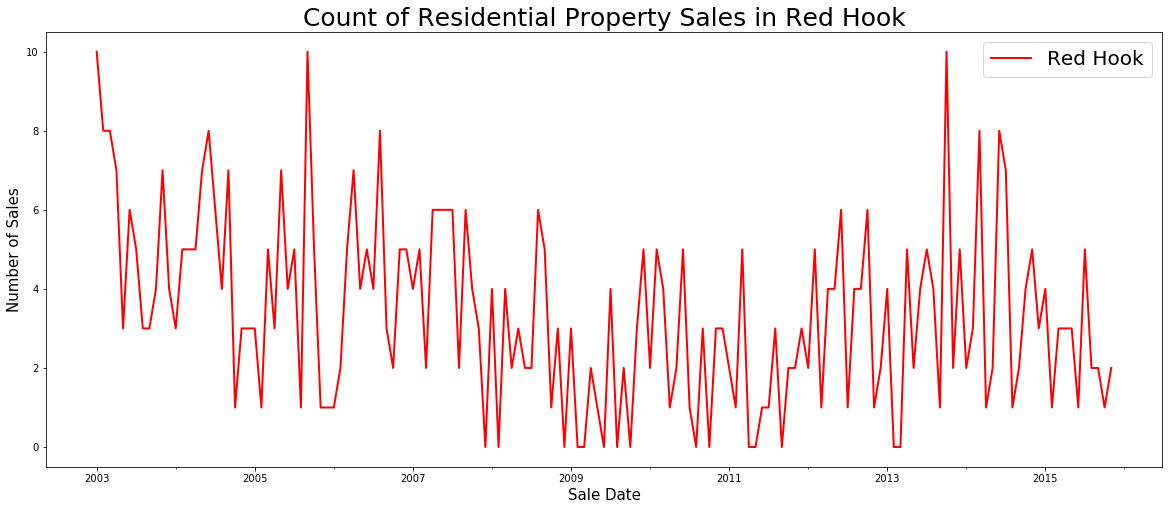

In [24]:
f, ax = plt.subplots(figsize=(20,8))
rh_res_counts['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='Red Hook',color='r')
plt.title("Count of Residential Property Sales in Red Hook", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Number of Sales", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

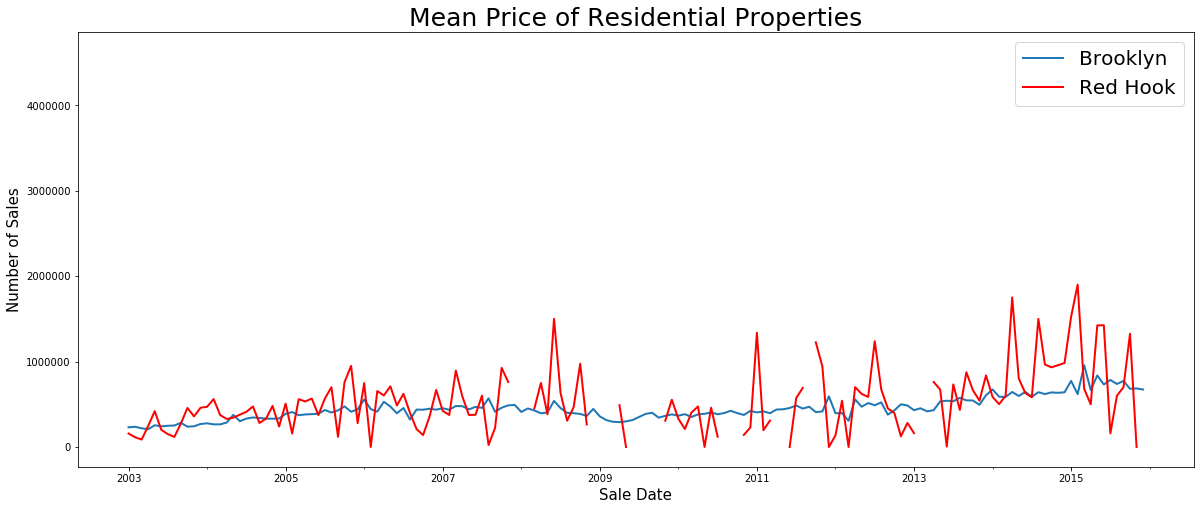

In [25]:
f, ax = plt.subplots(figsize=(20,8))
bk_res_mean['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='Brooklyn')
rh_res_mean['SALE PRICE'].plot(alpha=1,linewidth=2,ax=ax,label='Red Hook',color='r')
plt.title("Mean Price of Residential Properties", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Number of Sales", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

# Next steps/to dos:

* Figure out a better way to compare RH with Brooklyn
    * Max: Use the sale price / square footage for a better comparison.
* Fill in the missing months with zeros